

Predict the Relevance of Search Results on HomeDepot.com
--------------------------------------------------------


In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../data/"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
%matplotlib inline

attributes.csv
attributes_play.csv
product_descriptions.csv
product_descriptions_play.csv
sample_submission.csv
solution.csv
test.csv
test_play.csv
train.csv
train_play.csv



**Background**
--------------

Shoppers searching through Home Depot's product authority require correct results to their queries on home improvement.  Currently human raters gauge search relevance and the impact of potential changes to the search algorithm.  Home Depot aims to "develop a model that can accurately predict the relevance of search results."

Question
-----------

We are given a dataset of customers' search queries and the corresponding search results.  From this dataset we can ask the following: 

 - How relevant were the results? 
 - Did they match the query exactly?  
 - Did the customer find what he or she was looking for?

The search results are given relevancy scores from 1 (not relevant) to 3 (highly relevant).   

Breakdown
---------

<h3>What does the data look like?</h3>

In [2]:
# Load files
training_data = pd.read_csv("../data/train.csv", encoding="ISO-8859-1")
testing_data = pd.read_csv("../data/test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('../data/attributes.csv')
descriptions = pd.read_csv('../data/product_descriptions.csv')

In [3]:
# Look at data column names
print("Test data columns")
print(testing_data.columns)
print("Attribute data columns")
print(attribute_data.columns)
print("Description data columns")
print(descriptions.columns)

Test data columns
Index(['id', 'product_uid', 'product_title', 'search_term'], dtype='object')
Attribute data columns
Index(['product_uid', 'name', 'value'], dtype='object')
Description data columns
Index(['product_uid', 'product_description'], dtype='object')


We note that the training and description data sets both have a column for 'product_uid'.  Thus we can merge the datasets according to the product_uid.

In [4]:
# Merge descriptions
training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")
print(training_data.columns)

Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance',
       'product_description'],
      dtype='object')


In [5]:
# See what the data looks like
print(training_data)

           id  product_uid                                      product_title  \
0           2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1           3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2           9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3          16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4          17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
5          18       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
6          20       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
7          21       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
8          23       100007  Lithonia Lighting Quantum 2-Light Black LED Em...   
9          27       100009  House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...   
10         34       100010       Valley View Industries Metal Stakes (4-Pack)   
11         35       100011  

From this we see that the same product such as "Simpson Strong Tie" appeared for two different search queries, namely "angle bracket" and "l bracket".  Thus let us take a product count grouping by product_uid. Then we will add this new column of data to our training_data.

In [6]:
# Merge product counts
product_counts = pd.DataFrame(pd.Series(training_data.groupby(
['product_uid']).size(), name='product_count'))

training_data = pd.merge(training_data, product_counts, 
                        left_on="product_uid", right_index=True,
                        how="left")
print(training_data[:50])

     id  product_uid                                      product_title  \
0     2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1     3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2     9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3    16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4    17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
5    18       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
6    20       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
7    21       100006  Whirlpool 1.9 cu. ft. Over the Range Convectio...   
8    23       100007  Lithonia Lighting Quantum 2-Light Black LED Em...   
9    27       100009  House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...   
10   34       100010       Valley View Industries Metal Stakes (4-Pack)   
11   35       100011  Toro Personal Pace Recycler 22 in. Variable Sp...   
12   37       100011  Tor

Now let's look at what's in "attribute_data.csv".  We see for each product it has several descriptors.  Bullet01 seems to represent general text.  We also have other product descriptors such as "MFG Brand Name", "Product Height" etc.

In [7]:
print(attribute_data)

         product_uid                         name  \
0           100001.0                     Bullet01   
1           100001.0                     Bullet02   
2           100001.0                     Bullet03   
3           100001.0                     Bullet04   
4           100001.0                     Bullet05   
5           100001.0                     Bullet06   
6           100001.0                     Bullet07   
7           100001.0                        Gauge   
8           100001.0                     Material   
9           100001.0               MFG Brand Name   
10          100001.0             Number of Pieces   
11          100001.0          Product Depth (in.)   
12          100001.0         Product Height (in.)   
13          100001.0         Product Weight (lb.)   
14          100001.0          Product Width (in.)   
15          100002.0           Application Method   
16          100002.0        Assembled Depth (in.)   
17          100002.0       Assembled Height (i

**How can we merge the attribute file with our training data?**

In [8]:
# merge brand names
brand_names = attribute_data[attribute_data.name == "MFG Brand Name"][['product_uid', 'value']].rename(columns={"value": "brand_name"})
training_data = pd.merge(training_data, brand_names, on="product_uid", how="left")

In [9]:
print(brand_names)

         product_uid                        brand_name
9           100001.0                Simpson Strong-Tie
37          100002.0    BEHR Premium Textured DeckOver
69          100003.0                          STERLING
93          100004.0                       Grape Solar
122         100005.0                             Delta
163         100006.0                         Whirlpool
204         100007.0                 Lithonia Lighting
236         100008.0                              Teks
256         100009.0                     House of Fara
283         100010.0            Valley View Industries
318         100011.0                              Toro
363         100012.0                       Hampton Bay
389         100013.0                      InSinkErator
405         100014.0                        Rubbermaid
423         100015.0                 Backyard X-Scapes
441         100016.0                            Sunjoy
459         100017.0              MD Building Products
477       

In [10]:
# Let's check to see if there are any missing values in our data
print(str(training_data.info()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74067 entries, 0 to 74066
Data columns (total 8 columns):
id                     74067 non-null int64
product_uid            74067 non-null int64
product_title          74067 non-null object
search_term            74067 non-null object
relevance              74067 non-null float64
product_description    74067 non-null object
product_count          74067 non-null int64
brand_name             56511 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 5.1+ MB
None


In [11]:
# We note that brand_name has null values and replace them with "Unknown"
# Fill all products with no brand name
training_data.brand_name.fillna("Unknown", inplace=True)

# Print out the names of the products without a brand
print(training_data.product_title[training_data.brand_name == "Unknown"])

198      Shark Navigator Lift-Away Deluxe Bagless Vacuu...
199      Shark Navigator Lift-Away Deluxe Bagless Vacuu...
219      Champion Power Equipment 3,100 Watt Gasoline P...
302      DEWALT 20-Volt Max Lithium-Ion Cordless Combo ...
881                Milwaukee Metal Hole Saw Kit (15-Piece)
1208     EGO 20 in. 56-Volt Lithium-Ion Walk-Behind Ele...
1219     Eclipse Tools Heat Shrink Tubing - Assorted Co...
1241     Trinity EcoStorage 36 in. x 14 in. 3-Tier Bamb...
1242     Trinity EcoStorage 36 in. x 14 in. 3-Tier Bamb...
1419     GE 4.6 cu. ft. Top Load Washer in White, ENERG...
1861     2 in. x 6 in. x 8 ft. #2 &amp; Better Kiln-Dri...
1862     2 in. x 6 in. x 8 ft. #2 &amp; Better Kiln-Dri...
1863     2 in. x 6 in. x 8 ft. #2 &amp; Better Kiln-Dri...
1864     2 in. x 6 in. x 8 ft. #2 &amp; Better Kiln-Dri...
1865     2 in. x 6 in. x 8 ft. #2 &amp; Better Kiln-Dri...
2007     Ekena Millwork 3-3/4 in. x 3-3/4 in. x 35-1/2 ...
2275     DEWALT 20-Volt MAX Lithium-Ion Cordless Combo .

In [12]:
# Description of training_data
print(str(training_data.describe()))

# We note that the mean relevance score is a 2.38 which shows the data 
# tends towards higher relevance scores.  On average there are about 2 
# of each product with a max of one product being returned for 21 different
# search queries.

                  id    product_uid     relevance  product_count
count   74067.000000   74067.000000  74067.000000   74067.000000
mean   112385.709223  142331.911553      2.381634       1.935450
std     64016.573650   30770.774864      0.533984       1.706594
min         2.000000  100001.000000      1.000000       1.000000
25%     57163.500000  115128.500000      2.000000       1.000000
50%    113228.000000  137334.000000      2.330000       1.000000
75%    168275.500000  166883.500000      3.000000       2.000000
max    221473.000000  206650.000000      3.000000      21.000000


In [13]:
# Let's check the distribution and spread of the relevance column
training_data.relevance.hist()
training_data.relevance.value_counts()

3.00    19125
2.33    16060
2.67    15202
2.00    11730
1.67     6780
1.33     3006
1.00     2105
2.50       19
2.25       11
2.75       11
1.75        9
1.50        5
1.25        4
Name: relevance, dtype: int64

From the above histogram I note that the data is highly skewed to the right with most of the products having high relevancy between 2 and 3.
 

In [14]:
# Now let's go through how many indoor and outdoor products we have
attribute_data.value[attribute_data.name == "Indoor/Outdoor"].value_counts()

Indoor                      7527
Indoor/Outdoor              3905
Outdoor                     1204
Indoor,Outdoor               256
Indoor/Outdoor (Covered)      47
Name: value, dtype: int64

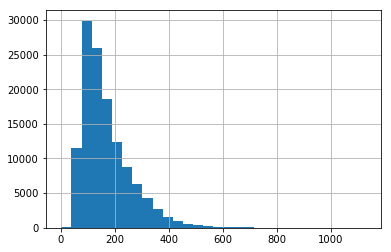

In [28]:
# What is the distribution of the product descriptions?
(descriptions.product_description.str.len()/5).hist(bins=30)

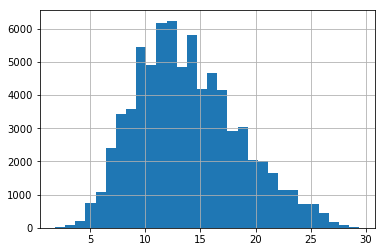

In [29]:
# What does the distribution of the string lengths for product title?
(training_data.product_title.str.len() / 5).hist(bins=30)

In [17]:
# Now let's get an idea of how many words are in each search_term
# Are people writing really long specific queries or general 
# one word queries?

(training_data.search_term.str.count("\\s+") + 1).hist(bins=30)

(training_data.search_term.str.count("\\s+") + 1).describe()

# We note that people search with 3 words on average with a 
# standard deviation of 1 word. This means that 66% of the data 
# lies within 2-4 word search queries

count    74067.000000
mean         3.159207
std          1.262096
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         14.000000
Name: search_term, dtype: float64

In [26]:
## ongmin: search term lengths note 0 = 1 word
# 6+ words  = 4.26%
# 7+ words  = 1.46%
# 8+ words  = 0.46%
# 9+ words  = 0.18%
training_data.search_term.str.count("\\s+").value_counts().sort_index()

0      4503
1     18386
2     26575
3     14847
4      6601
5      2076
6       741
7       204
8        80
9        10
10       31
11        9
13        4
Name: search_term, dtype: int64

In [18]:
# How many rows are there for each product_uid?
testing_data.product_uid.value_counts()

101892    52
101280    35
101442    35
101148    34
102456    31
100898    31
102162    30
104691    27
109594    27
101959    26
102235    26
102954    26
101312    26
101024    25
105369    25
102567    25
100941    24
104899    24
100065    24
100526    24
103763    24
101027    23
112119    22
118371    22
102304    22
117268    22
102891    22
100409    22
100885    22
101272    22
          ..
192787     1
182548     1
180501     1
186646     1
174360     1
178458     1
170270     1
168223     1
223520     1
221473     1
143627     1
141576     1
215204     1
147717     1
213157     1
219302     1
217255     1
207016     1
204969     1
211114     1
209067     1
196781     1
125168     1
116980     1
114933     1
119031     1
112890     1
110843     1
162050     1
110474     1
Name: product_uid, dtype: int64

In [19]:
# What words show up the most in the training_data? How does this
# compare to the most frequent words in the test_data?
# It should be a good match if the word is in the query and the 
# product name

import collections

words_search = collections.Counter()
for title in training_data.search_term:
    words_search.update(title.lower().split())
    
total_search = sum(words_search.values())

words_query = collections.Counter()
for title in training_data.product_title:
    words_query.update(title.lower().split())
    
total_query = sum(words_query.values())
print(words_search)
print(words_query)

Counter({'door': 2679, 'light': 2021, 'for': 1815, 'in': 1665, 'inch': 1487, 'wall': 1442, 'shower': 1429, 'with': 1417, 'white': 1354, 'wood': 1349, 'x': 1347, 'tile': 1338, 'and': 1165, 'paint': 1145, 'cabinet': 1061, 'outdoor': 1052, 'water': 1034, 'vanity': 977, 'kitchen': 969, 'bathroom': 963, 'doors': 960, 'gas': 925, 'led': 899, 'lights': 840, 'air': 839, 'ceiling': 805, 'sink': 801, '2': 780, 'faucet': 772, '1/2': 772, 'kit': 770, 'floor': 766, 'saw': 736, '4': 733, 'fan': 729, 'black': 727, 'pipe': 725, 'steel': 710, 'window': 697, 'lighting': 691, 'electric': 669, 'metal': 658, '1': 637, 'glass': 624, 'patio': 602, 'heater': 596, '3': 588, 'toilet': 580, 'pvc': 580, 'wire': 568, '6': 564, '12': 560, 'fence': 548, 'cover': 531, 'drill': 527, 'plastic': 521, 'bulb': 521, 'tub': 499, 'base': 498, 'top': 495, 'storage': 489, 'range': 487, 'bay': 486, 'panel': 477, 'bronze': 474, 'vinyl': 471, 'battery': 461, 'post': 460, 'round': 455, 'cabinets': 442, 'filter': 437, '1/4': 436, '

Now a key determinant for whether or not a query has a high relevance seems to be determined on how specific the query is. For example if a user provides specific dimensions then the result should match the dimensions for a high relevance.

In [20]:
# How many search terms contain numbers?
print("Contains numbers", training_data.search_term.str.contains("\\d", case=False).value_counts())

Contains numbers False    55811
True     18256
Name: search_term, dtype: int64


In [21]:
# Now we know that we want to use the attribute data.  Let's look
# at which variables show up most often in the attribute data.

attribute_counts = attribute_data.name.value_counts()
print(attribute_counts)

MFG Brand Name                       86250
Bullet02                             86248
Bullet03                             86226
Bullet04                             86174
Bullet01                             85940
Product Width (in.)                  61137
Bullet05                             60529
Product Height (in.)                 54698
Product Depth (in.)                  53652
Product Weight (lb.)                 45175
Bullet06                             44901
Color Family                         41508
Bullet07                             34349
Material                             31500
Color/Finish                         28564
Bullet08                             26645
Certifications and Listings          24583
Bullet09                             20567
Assembled Height (in.)               18299
Assembled Width (in.)                18263
Assembled Depth (in.)                18198
Product Length (in.)                 16705
Bullet10                             14763
Indoor/Outd

In [22]:
# This shows us that ~86,000 product descriptions include the brand
# name, ~41,000 include the color family, etc.  What are the values
# of these variables that come up the most often?

def summarize_values(name, values):
    values.fillna("", inplace=True)
    counts = collections.Counter()
    for value in values:
        counts[value.lower()] += 1
    
    total = sum(counts.values())
    print("{} counts ({:,} values)".format(name, total))
    for word, count in counts.most_common(20):
        print("{}: {:.1f}% ({:,})".format(word, 100. * count / total, count))

for attribute_name in ["Color Family", "Color/Finish", "Material", "MFG Brand Name", "Indoor/Outdoor", "Commercial / Residential"]:
    summarize_values("\n" + attribute_name, attribute_data[attribute_data.name == attribute_name].value)

/home/ongmin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)



Color Family counts (41,508 values)
white: 15.8% (6,546)
black: 7.5% (3,115)
brown: 5.6% (2,339)
gray: 4.6% (1,892)
whites: 4.4% (1,829)
chrome: 3.9% (1,616)
browns / tans: 3.5% (1,463)
red: 3.0% (1,239)
blacks: 3.0% (1,237)
bronze: 2.8% (1,151)
metallics: 2.6% (1,078)
nickel: 2.5% (1,028)
beige: 2.3% (950)
grays: 2.3% (939)
blue: 2.1% (891)
silver: 2.1% (871)
stainless steel: 2.0% (824)
beige / cream: 1.9% (788)
greens: 1.7% (713)
multi: 1.6% (669)

Color/Finish counts (28,564 values)
white: 14.4% (4,115)
black: 5.7% (1,628)
stainless steel: 3.7% (1,065)
chrome: 3.5% (995)
gray: 1.7% (482)
brushed nickel: 1.7% (473)
oil rubbed bronze: 1.3% (375)
polished chrome: 1.3% (370)
brown: 1.1% (328)
primed white: 1.1% (324)
clear: 1.1% (316)
red: 0.9% (251)
blue: 0.8% (218)
satin nickel: 0.7% (213)
beige: 0.7% (210)
silver: 0.7% (198)
biscuit: 0.7% (196)
almond: 0.7% (187)
stainless: 0.6% (180)
bronze: 0.6% (176)

Material counts (31,500 values)
steel: 13.2% (4,151)
metal: 9.6% (3,029)
plasti

In [23]:
# Now we know that we want to use the attribute data.  Let's look
# at which variables show up most often in the attribute data.

attribute_counts = attribute_data.name.value_counts()
print(attribute_counts)

MFG Brand Name                       86250
Bullet02                             86248
Bullet03                             86226
Bullet04                             86174
Bullet01                             85940
Product Width (in.)                  61137
Bullet05                             60529
Product Height (in.)                 54698
Product Depth (in.)                  53652
Product Weight (lb.)                 45175
Bullet06                             44901
Color Family                         41508
Bullet07                             34349
Material                             31500
Color/Finish                         28564
Bullet08                             26645
Certifications and Listings          24583
Bullet09                             20567
Assembled Height (in.)               18299
Assembled Width (in.)                18263
Assembled Depth (in.)                18198
Product Length (in.)                 16705
Bullet10                             14763
Indoor/Outd

In [24]:
# This shows us that ~86,000 product descriptions include the brand
# name, ~41,000 include the color family, etc.  What are the values
# of these variables that come up the most often?

def summarize_values(name, values):
    values.fillna("", inplace=True)
    counts = collections.Counter()
    for value in values:
        counts[value.lower()] += 1
    
    total = sum(counts.values())
    print("{} counts ({:,} values)".format(name, total))
    for word, count in counts.most_common(20):
        print("{}: {:.1f}% ({:,})".format(word, 100. * count / total, count))

for attribute_name in ["Color Family", "Color/Finish", "Material", "MFG Brand Name", "Indoor/Outdoor", "Commercial / Residential"]:
    summarize_values("\n" + attribute_name, attribute_data[attribute_data.name == attribute_name].value)

/home/ongmin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)



Color Family counts (41,508 values)
white: 15.8% (6,546)
black: 7.5% (3,115)
brown: 5.6% (2,339)
gray: 4.6% (1,892)
whites: 4.4% (1,829)
chrome: 3.9% (1,616)
browns / tans: 3.5% (1,463)
red: 3.0% (1,239)
blacks: 3.0% (1,237)
bronze: 2.8% (1,151)
metallics: 2.6% (1,078)
nickel: 2.5% (1,028)
beige: 2.3% (950)
grays: 2.3% (939)
blue: 2.1% (891)
silver: 2.1% (871)
stainless steel: 2.0% (824)
beige / cream: 1.9% (788)
greens: 1.7% (713)
multi: 1.6% (669)

Color/Finish counts (28,564 values)
white: 14.4% (4,115)
black: 5.7% (1,628)
stainless steel: 3.7% (1,065)
chrome: 3.5% (995)
gray: 1.7% (482)
brushed nickel: 1.7% (473)
oil rubbed bronze: 1.3% (375)
polished chrome: 1.3% (370)
brown: 1.1% (328)
primed white: 1.1% (324)
clear: 1.1% (316)
red: 0.9% (251)
blue: 0.8% (218)
satin nickel: 0.7% (213)
beige: 0.7% (210)
silver: 0.7% (198)
biscuit: 0.7% (196)
almond: 0.7% (187)
stainless: 0.6% (180)
bronze: 0.6% (176)

Material counts (31,500 values)
steel: 13.2% (4,151)
metal: 9.6% (3,029)
plasti